### 1. Outline the Analysis Steps:
- We’ll import libraries, load the data, and visualize it.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
# import tensorflow as tf
# from keras.layers import LSTM
current_dir = os.getcwd()
# Append the parent directory to sys.path
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
# ignore warrnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [3]:
from scripts.model_development import ModelBuilder
from scripts.Data_extract import WorldDataAnalysis

In [4]:
data_extracter =WorldDataAnalysis()

In [5]:
data_extracter.fetch_world_data()

Fetching world data...
Fetch complete. Data type: <class 'wbdata.client.DataFrame'>
World data fetched and filtered by date successfully.
        date  GDP Growth (%)  Inflation Rate (%)  Unemployment Rate (%)  \
0 2023-01-01        2.833509            5.635669               4.916572   
1 2022-01-01        3.238021            7.930929               5.260711   
2 2021-01-01        6.350090            3.475403               6.064446   
3 2020-01-01       -2.878323            1.905664               6.608805   
4 2019-01-01        2.675966            2.216776               5.598931   

  Exchange Rate (USD)  
0                None  
1                None  
2                None  
3                None  
4                None  
Data saved to 'world_data.csv'.


In [6]:
data_extracter.resample_to_daily()

World data resampled to daily frequency.
            GDP Growth (%)  Inflation Rate (%)  Unemployment Rate (%)  \
date                                                                    
1987-01-01        3.753409            5.710119                    NaN   
1987-01-02        3.753409            5.710119                    NaN   
1987-01-03        3.753409            5.710119                    NaN   
1987-01-04        3.753409            5.710119                    NaN   
1987-01-05        3.753409            5.710119                    NaN   

           Exchange Rate (USD)  
date                            
1987-01-01                None  
1987-01-02                None  
1987-01-03                None  
1987-01-04                None  
1987-01-05                None  


In [7]:
file_path ='../data/BrentOilPrices.csv'
data_extracter.load_oil_prices_from_csv(file_path=file_path)

Oil prices loaded successfully.
            Price
Date             
1987-05-20  18.63
1987-05-21  18.45
1987-05-22  18.55
1987-05-25  18.60
1987-05-26  18.63


In [8]:
data_extracter.merge_data()

Data merged successfully, maintaining only dates from oil prices data.
            GDP Growth (%)  Inflation Rate (%)  Unemployment Rate (%)  \
Date                                                                    
1987-05-20        3.753409            5.710119                    NaN   
1987-05-21        3.753409            5.710119                    NaN   
1987-05-22        3.753409            5.710119                    NaN   
1987-05-25        3.753409            5.710119                    NaN   
1987-05-26        3.753409            5.710119                    NaN   

           Exchange Rate (USD)  Price  
Date                                   
1987-05-20                None  18.63  
1987-05-21                None  18.45  
1987-05-22                None  18.55  
1987-05-25                None  18.60  
1987-05-26                None  18.63  
Merged data saved to 'merged_data.csv'.


In [9]:
merged_data =pd.read_csv('merged_data.csv')
merged_data.head()

,Date,GDP Growth (%),Inflation Rate (%),Unemployment Rate (%),Exchange Rate (USD),Price
0,1987-05-20,3.753409,5.710119,NaN,NaN,18.63
1,1987-05-21,3.753409,5.710119,NaN,NaN,18.45
2,1987-05-22,3.753409,5.710119,NaN,NaN,18.55
3,1987-05-25,3.753409,5.710119,NaN,NaN,18.60
4,1987-05-26,3.753409,5.710119,NaN,NaN,18.63


In [10]:
merged_data.isnull().sum()

Date                        0
GDP Growth (%)              0
Inflation Rate (%)          0
Unemployment Rate (%)     925
Exchange Rate (USD)      9011
Price                       0
dtype: int64

In [11]:
# Check for missing values and data types
print(merged_data.info())
print(merged_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   9011 non-null   object 
 1   GDP Growth (%)         9011 non-null   float64
 2   Inflation Rate (%)     9011 non-null   float64
 3   Unemployment Rate (%)  8086 non-null   float64
 4   Exchange Rate (USD)    0 non-null      float64
 5   Price                  9011 non-null   float64
dtypes: float64(5), object(1)
memory usage: 422.5+ KB
None
       GDP Growth (%)  Inflation Rate (%)  Unemployment Rate (%)  \
count     9011.000000         9011.000000            8086.000000   
mean         3.013317            4.782402               5.999068   
std          1.595337            2.448874               0.343139   
min         -2.878323            1.443857               5.133780   
25%          2.675966            2.860449               5.832310   
50%        

In [12]:
data =merged_data.drop(columns=['Exchange Rate (USD)'])
data.dropna(inplace=True)
data

,Date,GDP Growth (%),Inflation Rate (%),Unemployment Rate (%),Price
925,1991-01-02,1.210701,8.996939,5.133780,26.78
926,1991-01-03,1.210701,8.996939,5.133780,25.05
927,1991-01-04,1.210701,8.996939,5.133780,24.08
928,1991-01-07,1.210701,8.996939,5.133780,25.93
929,1991-01-08,1.210701,8.996939,5.133780,25.73
...,...,...,...,...,...
9006,2022-11-08,3.238021,7.930929,5.260711,96.85
9007,2022-11-09,3.238021,7.930929,5.260711,93.05
9008,2022-11-10,3.238021,7.930929,5.260711,94.25
9009,2022-11-11,3.238021,7.930929,5.260711,96.37


### Exploratory Data Analysis (EDA)

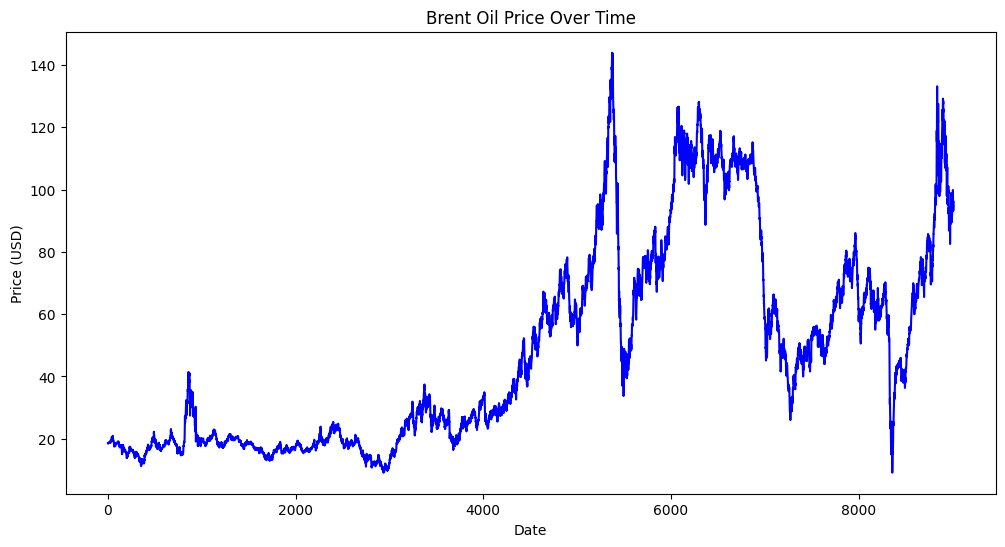

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(merged_data.index, merged_data['Price'], color='blue')
plt.title('Brent Oil Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show()

#### Correlation Analysis

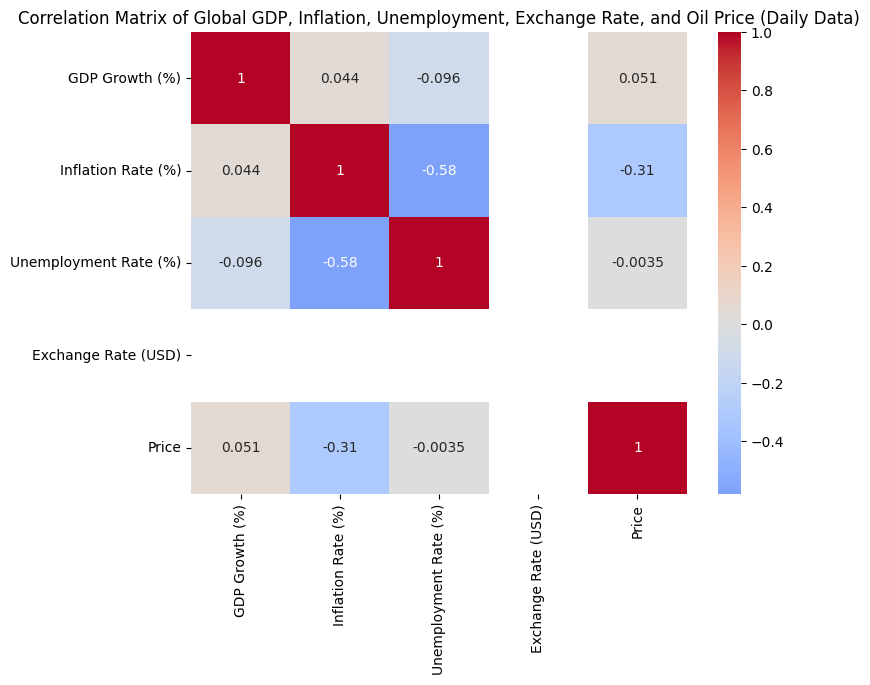

In [14]:
data_extracter.calculate_correlations()

In [15]:
data_extracter.specific_correlation(indicator1='GDP Growth (%)', indicator2='Price')

Correlation between GDP Growth (%) and Price: 0.05070956149309646


#### Analyze Potential Factors Influencing Oil Prices

Economic Indicators (GDP Growth, Inflation, Unemployment, Exchange Rate)

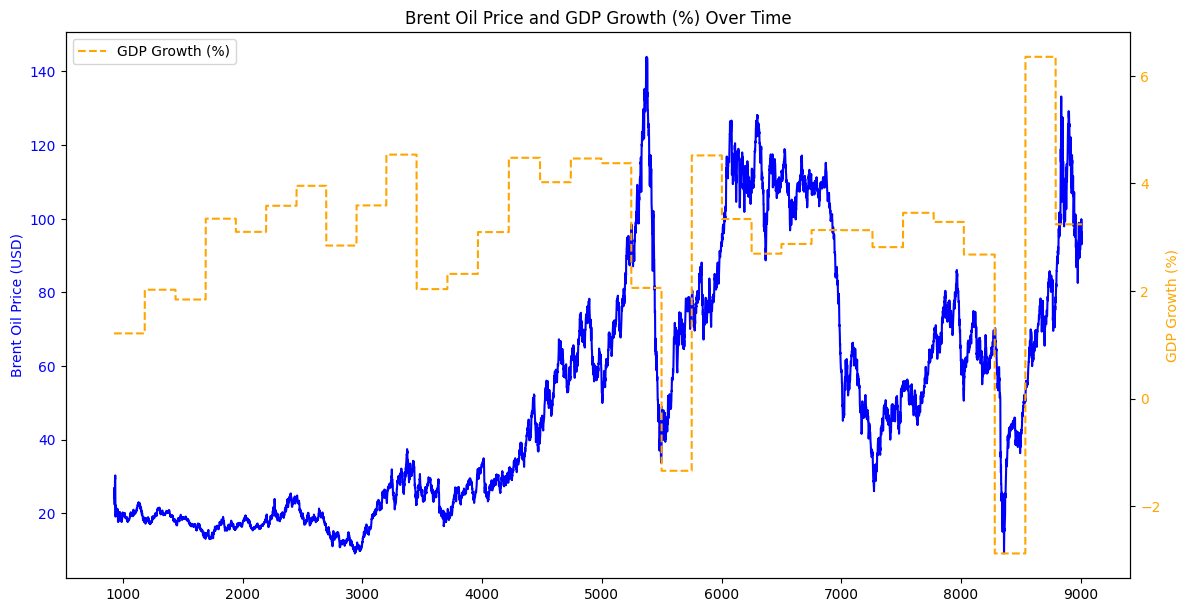

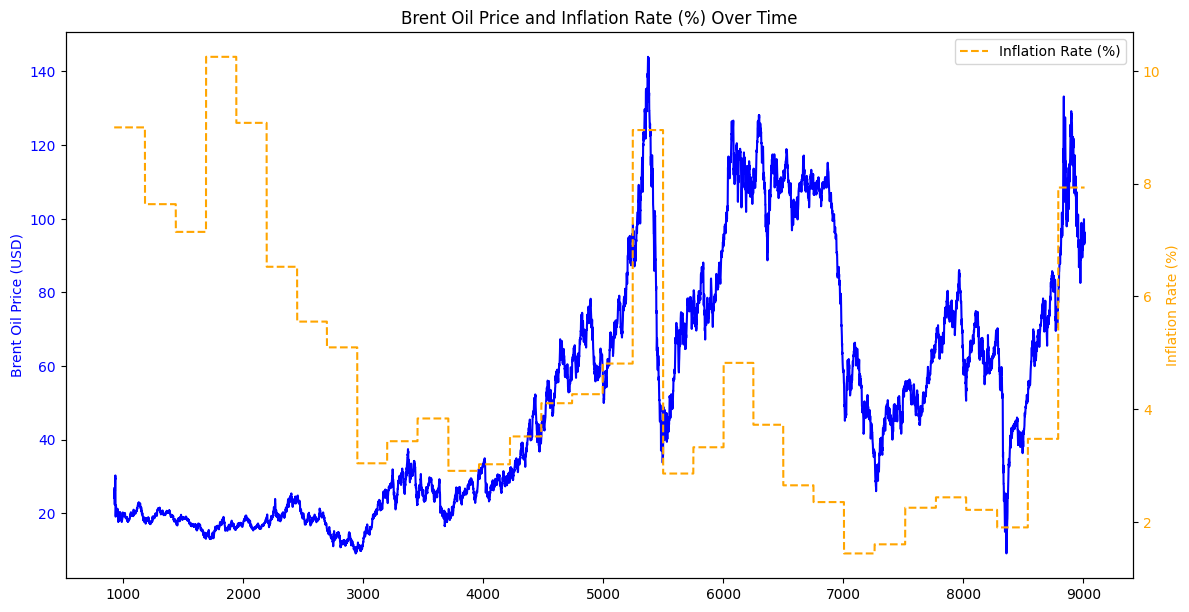

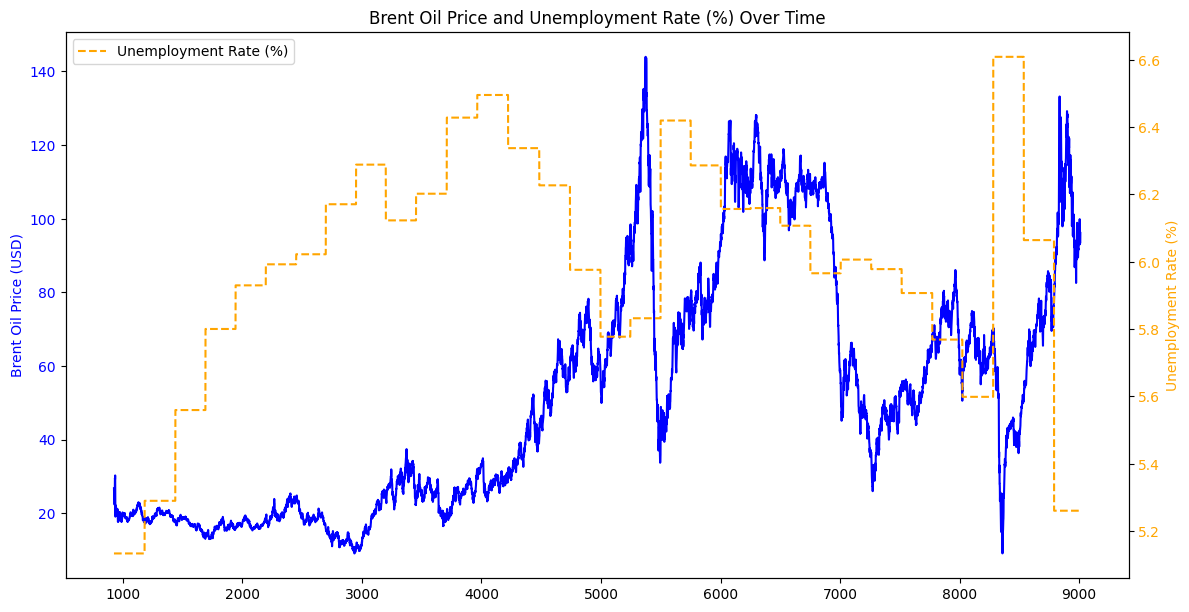

In [16]:
# Example plots for economic indicators against oil prices
for column in ['GDP Growth (%)', 'Inflation Rate (%)', 'Unemployment Rate (%)']:
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    ax1.plot(data.index, data['Price'], color='blue', label='Brent Oil Price')
    ax1.set_ylabel('Brent Oil Price (USD)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    ax2 = ax1.twinx()
    ax2.plot(data.index, data[column], color='orange', linestyle='--', label=column)
    ax2.set_ylabel(column, color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    
    fig.tight_layout()
    plt.title(f"Brent Oil Price and {column} Over Time")
    plt.legend()
    plt.show()


### 2. Stationarity Check:
- Check if the data is stationary using the Augmented Dickey-Fuller (ADF) test, which is necessary for ARIMA.

In [17]:
from scripts.oile_price_eda_script import BrentOilPricesEDA

In [18]:
file_path = '../data/BrentOilPrices.csv'  
processor = BrentOilPricesEDA(file_path=file_path)

In [19]:
processor.check_stationarity()

##### Before applying any statistical model on a Time Series, the series has to be staionary, which means that, over different time periods:-

- **a)** It should have constant mean.
- **b)** It should have constant variance or standard deviation.
- **c)** Auto-covariance should not depend on time.

### 2. Advanced Time Series Modeling

In [20]:
model_builder = ModelBuilder()

#### Data Spliting

In [21]:
# Split data into 80% train and 20% test sets
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

##### Vector Autoregression (VAR) Model

In [22]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Define ADF test function
def adf_test(series):
    result = adfuller(series)
    return {'ADF Statistic': result[0], 'p-value': result[1]}

# Check for stationarity and difference if necessary
stationary_data = pd.DataFrame()
for column in data.columns:
    series = data[column].dropna()
    adf_result = adf_test(series)
    
    if adf_result['p-value'] > 0.05:
        print(f"{column} is non-stationary (p-value: {adf_result['p-value']}). Differencing applied.")
        stationary_data[column] = series.diff().dropna()
    else:
        print(f"{column} is stationary (p-value: {adf_result['p-value']}). No differencing applied.")
        stationary_data[column] = series
        

ValueError: could not convert string to float: '1991-01-02'

In [35]:
# Convert all columns to numeric (in case of any mixed types)
stationary_data = stationary_data.apply(pd.to_numeric, errors='coerce')

# Handle any remaining NaN values (e.g., by forward filling)
stationary_data = stationary_data.fillna(method='ffill').dropna()

# Splitting the data into train and test sets
train_size = int(0.8 * len(stationary_data))
train_data = stationary_data[:train_size]
test_data = stationary_data[train_size:]

# Ensure all columns are numeric and free from NaN in train_data
train_data = train_data.dropna()

# Fit the VAR model on the training data
model = VAR(train_data)
results = model.fit(maxlags=15, ic='aic')

# Forecasting
lag_order = results.k_ar
forecast_input = train_data.values[-lag_order:]
forecasted_values = results.forecast(y=forecast_input, steps=len(test_data))

# Convert forecasts to DataFrame for easy handling
forecast_df = pd.DataFrame(forecasted_values, index=test_data.index, columns=test_data.columns)

ValueError: maxlags is too large for the number of observations and the number of equations. The largest model cannot be estimated.

In [36]:
# Calculate RMSE and MAE for numeric columns only, excluding 'Date'
metrics = {
    'RMSE': {},
    'MAE': {}
}

# Filter out the non-numeric columns (like 'Date')
for column in test_data.columns:
    if pd.api.types.is_numeric_dtype(test_data[column]) and column != 'Date':
        actual = test_data[column]
        forecast = forecast_df[column]
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(actual, forecast))
        mae = mean_absolute_error(actual, forecast)
        
        # Store metrics
        metrics['RMSE'][column] = rmse
        metrics['MAE'][column] = mae

# Calculate aggregate metrics
aggregate_rmse = np.sqrt(np.mean([value**2 for value in metrics['RMSE'].values()]))
aggregate_mae = np.mean(list(metrics['MAE'].values()))

# Display the metrics summary
print("\nModel Performance Metrics:")
for metric, values in metrics.items():
    print(f"{metric}:")
    for key, value in values.items():
        print(f"  {key}: {value:.4f}")

# Display aggregate metrics
print(f"\nAggregate RMSE: {aggregate_rmse:.4f}")
print(f"Aggregate MAE: {aggregate_mae:.4f}")


Model Performance Metrics:
RMSE:
MAE:

Aggregate RMSE: nan
Aggregate MAE: nan


In [23]:
print(stationary_data.columns)

RangeIndex(start=0, stop=0, step=1)


In [25]:
print(stationary_data.head())

Empty DataFrame
Columns: []
Index: []


In [37]:
from statsmodels.tsa.arima.model import ARIMA
# Splitting the data into training and test sets
train_size = int(len(stationary_data) * 0.8)  # 80% training data
train_series = stationary_data['Price'][:train_size]  # Adjust 'Price' based on your DataFrame's column name
test_series = stationary_data['Price'][train_size:]

# Fit the ARIMA model
p, d, q = 1, 0, 1  # Set the appropriate values for ARIMA parameters
arima_model = ARIMA(train_series, order=(p, d, q))
arima_model_fitted = arima_model.fit()

# Forecast
forecast_steps = len(test_series)
pred = arima_model_fitted.forecast(steps=forecast_steps)

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(test_series, pred))
mae = mean_absolute_error(test_series, pred)

# Output results
print("ARIMA Model RMSE:", rmse)
print("ARIMA Model MAE:", mae)

KeyError: 'Price'

### Time Series Modeling - ARIMA

In [24]:
# Forecast future price using ARIMA
arima_forecast = arima_result.forecast(steps=30)
plt.figure(figsize=(14, 6))
plt.plot(data.index[-100:], data['Price'][-100:], color='blue', label='Historical')
plt.plot(pd.date_range(data.index[-1], periods=30, freq='B'), np.exp(arima_forecast.cumsum()) * data['Price'].iloc[-1], color='green', label='ARIMA Forecast')
plt.title("ARIMA Forecast for Brent Oil Price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

NameError: name 'arima_model' is not defined